#### Imports

In [1]:
import pickle
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
import os
import cv2
from scipy import ndimage
import skimage.exposure as skie
from skimage import transform
import skimage.exposure as exposure
from PIL import Image
%matplotlib inline

### Step 0: Load Traffic Signs Data

In [2]:
def open_file(filename):
    with open(filename, mode='rb') as f:
        return pickle.load(f)
    
def get_signs(filename):
    with open(filename) as f:
        signs_dict = []
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            signs_dict.append({'classID': row[0], 'name': row[1]})
        return signs_dict

train = open_file('./traffic-signs-data/train.p')
valid = open_file('./traffic-signs-data/valid.p')
test = open_file('./traffic-signs-data/test.p')

X_train = train['features']
y_train = train['labels']

X_valid = valid['features']
y_valid = valid['labels']

X_test = test['features']
y_test = test['labels']

signs_dict = get_signs('signnames.csv')

### Step 1: Dataset Summary & Exploration

In [3]:
n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Visualize images in the training set

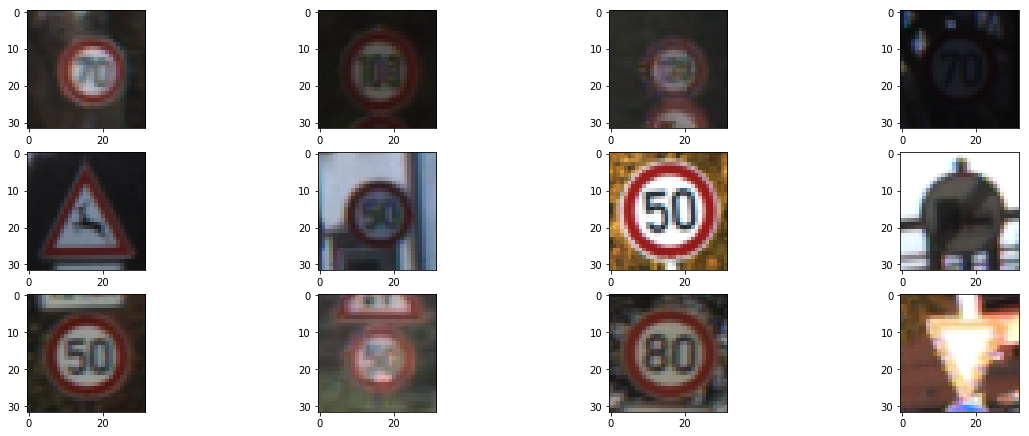

In [4]:
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(random.choice(X_train))
plt.show()

#### Train set distribution across 43 sign types

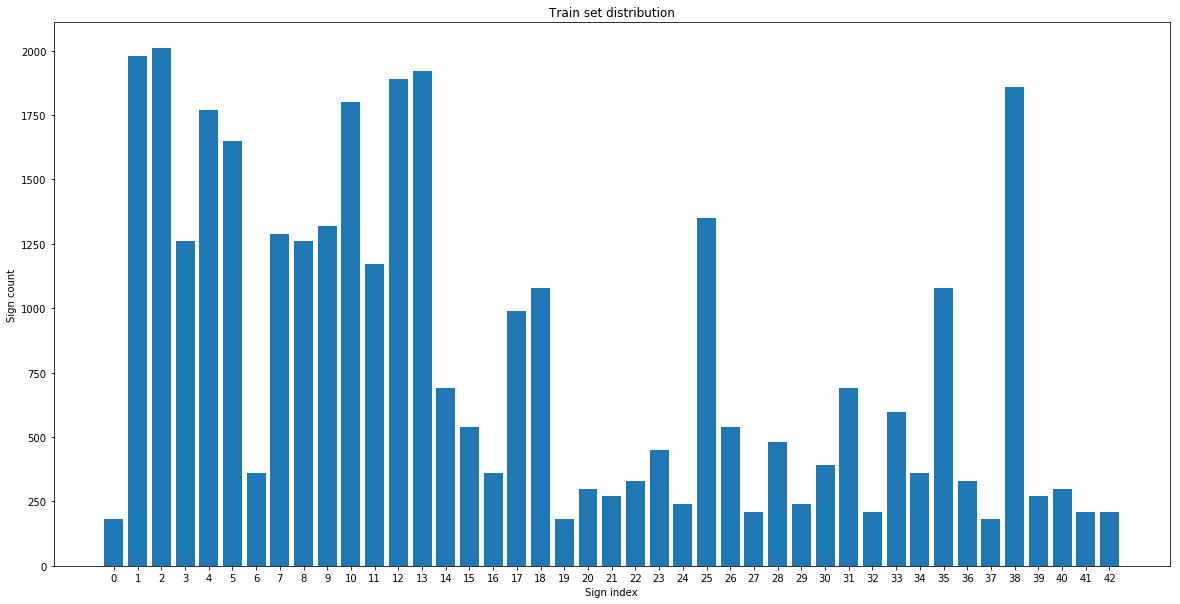

In [5]:
labels, count = np.unique(y_train, return_counts = True)
plt.figure(figsize=(20,10))
plt.bar(labels, count, width = .8)
plt.xticks(labels)
plt.title('Train set distribution')
plt.xlabel('Sign index')
plt.ylabel('Sign count') 
plt.show()

#### Valid set distribution across 43 sign types

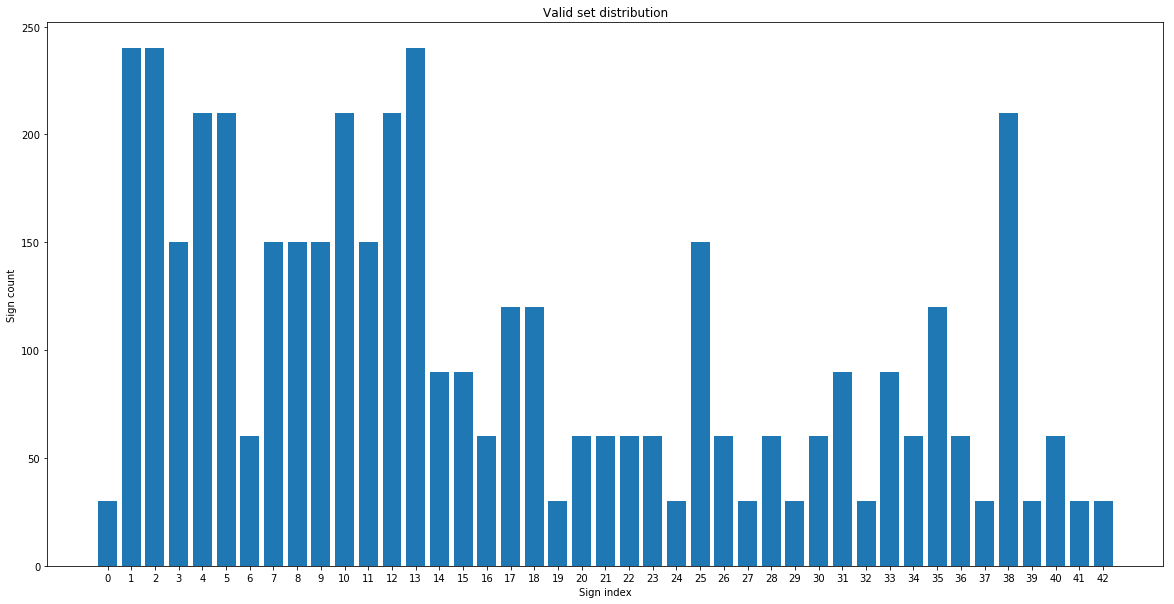

In [6]:
labels, count = np.unique(y_valid, return_counts = True)
plt.figure(figsize=(20,10))
plt.bar(labels, count, width = .8)
plt.xticks(labels)
plt.title('Valid set distribution')
plt.xlabel('Sign index')
plt.ylabel('Sign count') 
plt.show()

#### Test set distribution across 43 sign types

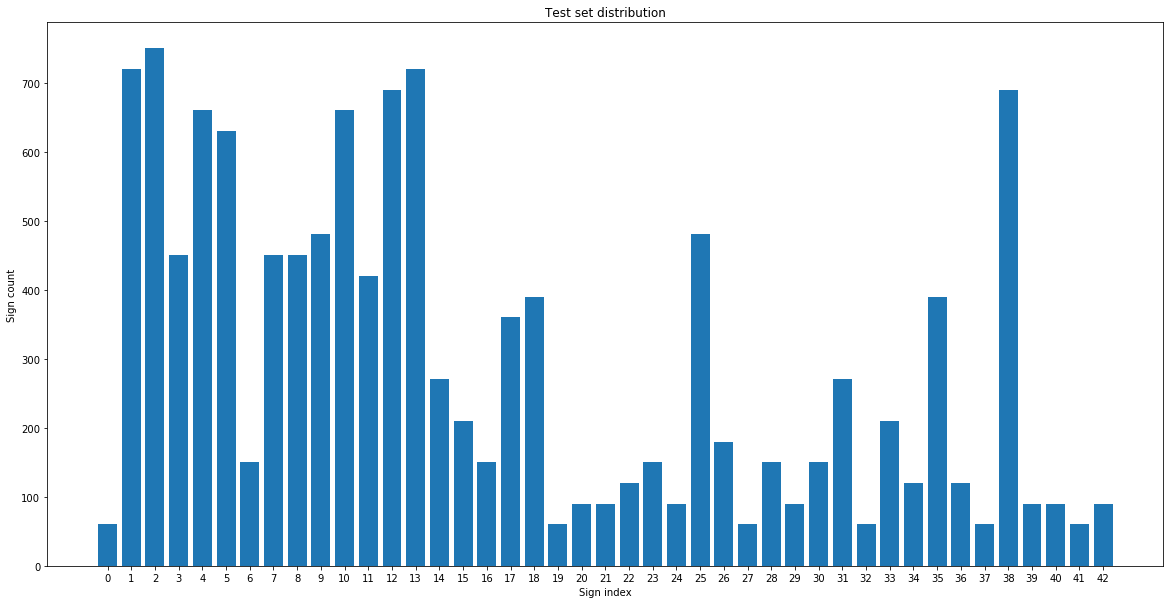

In [7]:
labels, count = np.unique(y_test, return_counts = True)
plt.figure(figsize=(20,10))
plt.bar(labels, count, width = .8)
plt.xticks(labels)
plt.title('Test set distribution')
plt.xlabel('Sign index')
plt.ylabel('Sign count') 
plt.show()

#### Augment data set

In [8]:
def rotate(image):
    r = random.randint(-20,20)
    return ndimage.rotate(image, r, reshape=False)

def perspective(image):
    def r(x, y):
        return random.randint(x,y)
    x1, y1 = r(-2,7), r(-2, 7)
    x2, y2 = r(28,32), r(0,5)
    x3, y3 = r(-2,7), r(25,32)
    x4, y4 = r(20,32), r(24,32)
    pts1 = np.float32([[5,5],[28,3],[3,28],[23,28]])
    pts2 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

def exposure(image):
    hoff, voff = random.uniform(.1, 10), random.randint(70, 90)
    v_min, v_max = np.percentile(image, (hoff, voff))
    image = skie.exposure.rescale_intensity(image, in_range=(v_min, v_max))
    return image

def augment(img):
    img = exposure(img)
    img = perspective(img)
    img = rotate(img)
    return img

X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)
XA = []
for i, (x, y) in enumerate(zip(X_train, y_train)):
    labels, index, count = np.unique(y_train, return_inverse=True, return_counts=True)
    if count[index[i]] < 750:
        for _ in range(15):
            XA.append(augment(X_train[i]))
            y_train = np.append(y_train, labels[index[i]])
        
        
X_train = np.concatenate((X_train, XA), axis=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

#### Visualize new train data set distribution

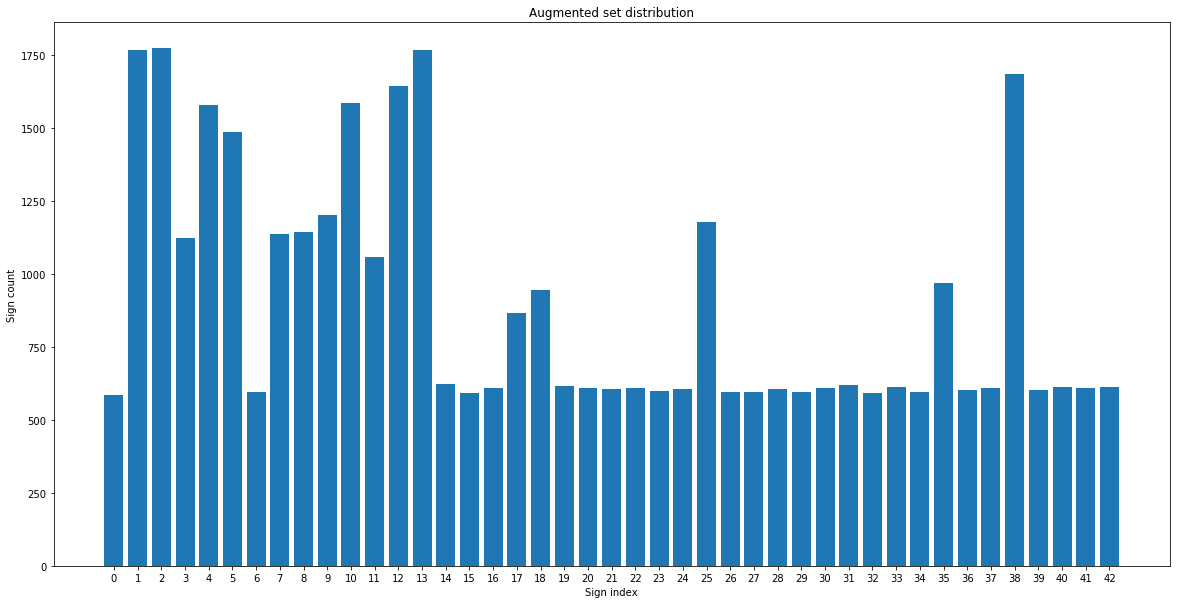

(38627,)


In [9]:
labels, count = np.unique(y_train, return_counts = True)
plt.figure(figsize=(20,10))
plt.bar(labels, count, width = .8)
plt.xticks(labels)
plt.title('Augmented set distribution')
plt.xlabel('Sign index')
plt.ylabel('Sign count') 
plt.show()
print(y_train.shape)

#### Visualize data set sample images

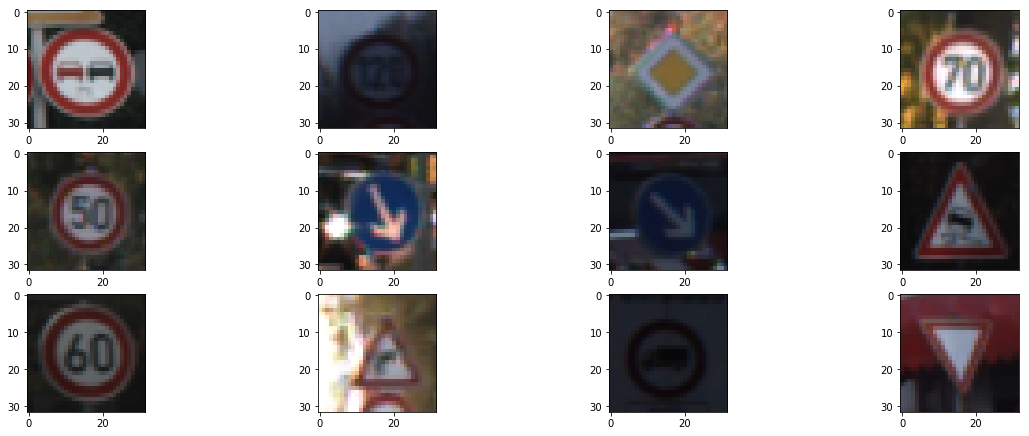

In [10]:
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(random.choice(X_train).squeeze(), cmap="gray")
plt.show()

#### Pre-process the Data Set

In [11]:
def grayScale(data):
    return np.dot(data[...,:], [0.299, 0.587, 0.114])

def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def meanSubtraction(data):
    d = [img - np.mean(img) for img in data]
    return d

def process(data):
    data = grayScale(data)
    data = normalize(data)
    data = meanSubtraction(data)
    data = np.reshape(data, (-1, 32, 32, 1))
    return data

#### Visualize each pre-process step

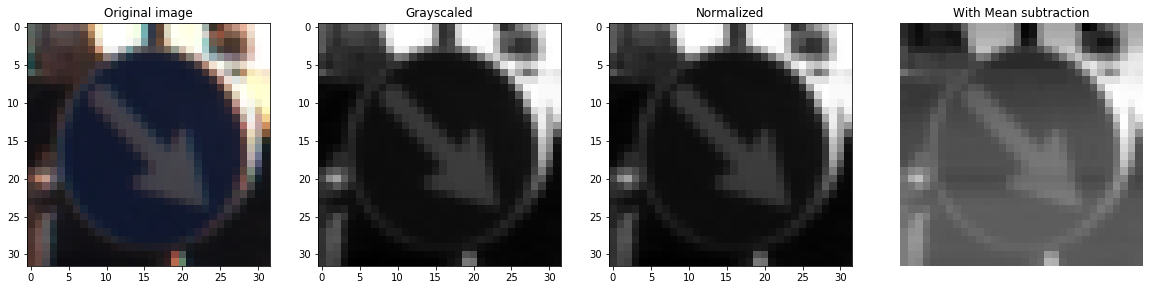

In [12]:
plt.figure(figsize=(20,10))

image = random.choice(X_train)

plt.subplot(1, 4, 1)
plt.title('Original image')
plt.imshow(image)

plt.subplot(1, 4, 2)
plt.title('Grayscaled')
plt.imshow(grayScale(image), cmap="gray")

plt.subplot(1, 4, 3)
plt.title('Normalized')
plt.imshow(normalize(grayScale(image)), cmap="gray")

plt.subplot(1, 4, 4)
plt.title('With Mean subtraction')
plt.imshow(meanSubtraction(normalize(grayScale(image))), cmap="gray")

plt.axis('off')    
plt.show()

#### Pre-process dataset

In [13]:
X_train = np.array(process(X_train))
X_valid = np.array(process(X_valid))
X_test = np.array(process(X_test))

#### Visualize processed images

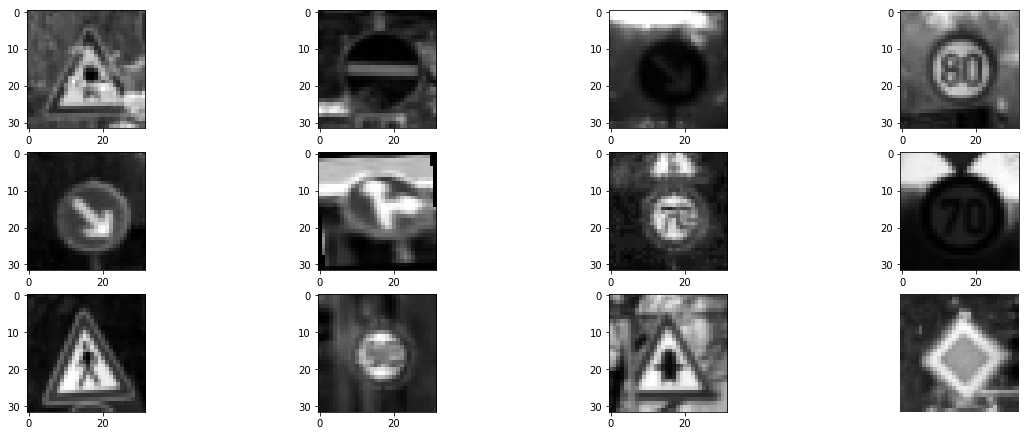

In [14]:
plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(random.choice(X_train).squeeze(), cmap='gray')
plt.axis('off')    
plt.show()

#### Model helper functions

In [15]:
def prep_data_augment(image):
    image = tf.image.random_brightness(image, max_delta=63/255.0)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    image = tf.image.random_flip_up_down(image)
    return image

def data_augment(input_tensor):
    output_tensor = tf.map_fn(prep_data_augment, input_tensor)
    return output_tensor

def batch_norm(x, n_out, phase_train):
    beta = tf.Variable(tf.constant(0.0, shape=[n_out]), name='beta', trainable=True)
    gamma = tf.Variable(tf.constant(1.0, shape=[n_out]), name='gamma', trainable=True)
    batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.5)
    def mean_var_with_update():
        ema_apply_op = ema.apply([batch_mean, batch_var])
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)

    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema.average(batch_mean), ema.average(batch_var)))
    normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

#### Model architecture

In [16]:
def CNN(x, keep_conv, keep_hidden, istraining):    
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma), name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = batch_norm(conv1, 32, istraining)
    conv1 = tf.nn.relu(conv1)    

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma), name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = batch_norm(conv2, 64, istraining)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.dropout(conv2, keep_conv)
    
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 96), mean = mu, stddev = sigma), name="conv4_W")
    conv3_b = tf.Variable(tf.zeros(96))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = batch_norm(conv3, 96, istraining)
    conv3 = tf.nn.relu(conv3)
    conv3 = tf.nn.dropout(conv3, keep_conv)

    conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 96, 128), mean = mu, stddev = sigma), name="conv5_W")
    conv4_b = tf.Variable(tf.zeros(128))
    conv4 = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b
    conv4 = batch_norm(conv4, 128, istraining)
    conv4 = tf.nn.relu(conv4)
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4 = tf.nn.dropout(conv4, keep_conv)

    fc0 = flatten(conv4)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 502), mean = mu, stddev = sigma), name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(502))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_hidden)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(502, 502), mean = mu, stddev = sigma), name="fc1_W")
    fc2_b = tf.Variable(tf.zeros(502))
    fc2 = tf.matmul(fc1, fc2_W) + fc1_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_hidden)
    
    fc3_W = tf.Variable(tf.truncated_normal(shape=(502, 43), mean = mu, stddev = sigma), name="fc3_W")
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    l2_loss = (tf.nn.l2_loss(conv1_W) + 
               tf.nn.l2_loss(conv2_W) +
               tf.nn.l2_loss(conv3_W) + 
               tf.nn.l2_loss(conv4_W) + 
               tf.nn.l2_loss(fc1_W) + 
                tf.nn.l2_loss(fc2_W) + 
               tf.nn.l2_loss(fc3_W)) * 0.00001 
    
    return logits, l2_loss

#### Tensor variables and placeholders

In [17]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_conv = tf.placeholder(tf.float32) 
keep_hidden = tf.placeholder(tf.float32) 
istraining = tf.placeholder(tf.bool)

rate = 0.0005
    
logits, l2_loss = CNN(data_augment(x), keep_conv, keep_hidden, istraining)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Validade Data set

In [18]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_conv: 1.0, keep_hidden: 1.0, istraining: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def calculate_loss(y, pred):
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))

#### Train Data set

In [19]:
EPOCHS = 120
BATCH_SIZE = 128 

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    output = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train) 
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, cross_entropy = sess.run(
                [training_operation, loss_operation], 
                feed_dict={x: batch_x, y: batch_y, keep_conv: 0.8, keep_hidden: 0.5, istraining: True})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Loss = {:.4f}".format(cross_entropy))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './cnn')
    print("Model saved")

Training...

EPOCH 1 ...
Loss = 3.8613
Train Accuracy = 0.045
Validation Accuracy = 0.043

EPOCH 2 ...
Loss = 3.7304
Train Accuracy = 0.055
Validation Accuracy = 0.051

EPOCH 3 ...
Loss = 3.6387
Train Accuracy = 0.068
Validation Accuracy = 0.077

EPOCH 4 ...
Loss = 3.6895
Train Accuracy = 0.154
Validation Accuracy = 0.154

EPOCH 5 ...
Loss = 3.4227
Train Accuracy = 0.259
Validation Accuracy = 0.253

EPOCH 6 ...
Loss = 2.8594
Train Accuracy = 0.298
Validation Accuracy = 0.297

EPOCH 7 ...
Loss = 2.9898
Train Accuracy = 0.395
Validation Accuracy = 0.401

EPOCH 8 ...
Loss = 2.4533
Train Accuracy = 0.477
Validation Accuracy = 0.479

EPOCH 9 ...
Loss = 2.0943
Train Accuracy = 0.536
Validation Accuracy = 0.537

EPOCH 10 ...
Loss = 2.1353
Train Accuracy = 0.592
Validation Accuracy = 0.593

EPOCH 11 ...
Loss = 2.1229
Train Accuracy = 0.599
Validation Accuracy = 0.601

EPOCH 12 ...
Loss = 1.7087
Train Accuracy = 0.653
Validation Accuracy = 0.658

EPOCH 13 ...
Loss = 1.6696
Train Accuracy = 0.68

#### Test Data set

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./cnn
Test Accuracy = 0.982


### Step 3: Test a Model on New Images

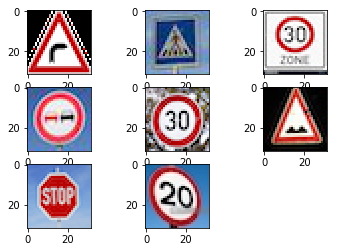

In [21]:
def load_new_images(path):    
    files  = [path + file for file in os.listdir(path)]
    images = []
    for image in files:
        image = Image.open(image)
        image = image.convert('RGB')
        image = np.array(list(image.getdata()), dtype='uint8')
        image = np.reshape(image, (32, 32, 3))
        images.append(image)

    return np.array(images, dtype='uint8')
    
images = load_new_images('test-images/')

for i in range(len(images)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])

images = process(images)
plt.show()

#### Predict the Sign Type for Each Image

In [22]:
prediction = tf.argmax(logits,1)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = prediction.eval(feed_dict={x: images, keep_conv: 1.0, keep_hidden: 1.0, istraining: False})
    for index in range(len(output)):
        print(signs_dict[output[index]]['name'])

INFO:tensorflow:Restoring parameters from ./cnn
Dangerous curve to the right
Bumpy road
Speed limit (30km/h)
No passing
Speed limit (30km/h)
Bumpy road
Stop
Speed limit (20km/h)


#### Performance Analysis

The model predicted 7 images out 8 correctly. These german traffic signs images were taken from the internet and they.

It's good to note these images have a good balance of quality and lightening. Going further, it would be good to check predictions against images that are not from the german traffic and/or signs that overal present some kind of modification such as erosion, missing parts or graphited parts.

#### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./cnn


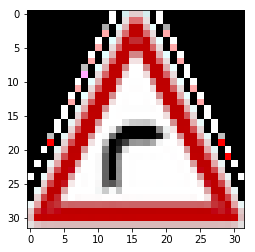

Dangerous curve to the right  100.0
Slippery road  0.0
No passing for vehicles over 3.5 metric tons  0.0
End of all speed and passing limits  0.0



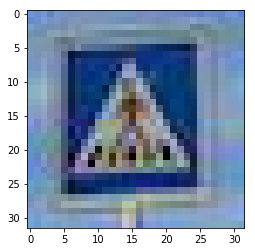

Bumpy road  85.0
Road work  15.0
Bicycles crossing  0.0
Yield  0.0



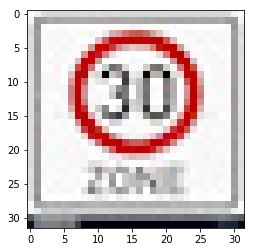

Speed limit (30km/h)  100.0
Speed limit (80km/h)  0.0
Speed limit (50km/h)  0.0
Speed limit (20km/h)  0.0



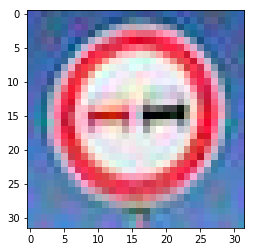

No passing  100.0
Slippery road  0.0
No passing for vehicles over 3.5 metric tons  0.0
Vehicles over 3.5 metric tons prohibited  0.0



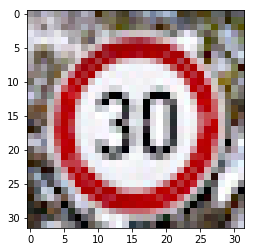

Speed limit (30km/h)  100.0
Speed limit (80km/h)  0.0
Speed limit (50km/h)  0.0
Speed limit (20km/h)  0.0



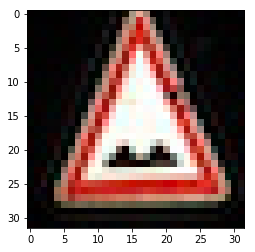

Bumpy road  100.0
Road work  0.0
Yield  0.0
Slippery road  0.0



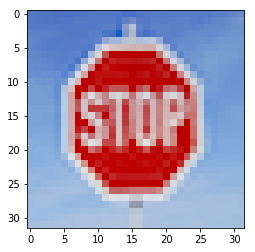

Stop  100.0
No entry  0.0
Speed limit (120km/h)  0.0
Speed limit (20km/h)  0.0



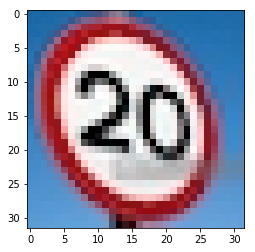

Speed limit (20km/h)  100.0
Speed limit (30km/h)  0.0
Roundabout mandatory  0.0
Speed limit (120km/h)  0.0



In [23]:
softmax = tf.nn.softmax(logits)
imgs = load_new_images('test-images/')
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmaxes, indices = sess.run(tf.nn.top_k(softmax, k=5), feed_dict={x: images, keep_conv: 1.0, keep_hidden: 1.0, istraining: False})
    for n in range(0, len(imgs)):
        plt.imshow(imgs[n], cmap='gray')
        plt.show()
        for i in range(4):
            signname = signs_dict[indices[n][i]]['name']
            prediction = softmaxes[n][i]
            print(signname + ' ', round(prediction * 100))
        print()